# Topic modelling with Gensim

In this notebook Gensim is used to find topics from the documents, we first study coherence measures to find the number of topics in the collection, then we visualize results.

The basic idea is to study the differences between topics in different times. So we first present the methodology followed given an era, and then perform the study on all eras.

In [1]:
# import sys
# sys.path.append("..")

# utils
import json
import numpy as np

# topic modelling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaMulticore, LdaModel

# visualization
from pprint import pprint
import matplotlib.pyplot as plt
import pyLDAvis
from pyLDAvis import gensim_models

In [2]:
import warnings
warnings.filterwarnings('ignore')

/home/fran/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loading the tokenized documents

In [3]:
tokens = json.load(open("../data/processed/filtered_tokens.json", "r"))

### Creating required structures
The topic modelling requires this three structures to work, the first one gives a mapping from an id to a word, 
second one is the tokenized collection, and the third one is a list for each document of word id, frequency.

In [4]:
id2word = corpora.Dictionary(tokens)
texts = tokens
corpus = [id2word.doc2bow(text) for text in texts]

print(f"Corpus[0]: {corpus[0][:5]}...")
print(f"id2word[0]: {id2word[0]}")
print(f"Corpus[0] readable: {[(id2word[cp[0]], cp[1]) for cp in corpus[0][:5]]}...")

Corpus[0]: [(0, 2), (1, 1), (2, 1), (3, 1), (4, 1)]...
id2word[0]: absence
Corpus[0] readable: [('absence', 2), ('accomplice', 1), ('additionally', 1), ('admission', 1), ('advise', 1)]...


### Fitting LDA models and computing coherence measures

Lda is unsupervised, a crucial parameter is the number of topics to find in the collection. To avoid choosing at random one could compute the coherence measure given a certain number of topics and pick the highest coherence.

To do so, different models are fitted, and the best one, according to coherence is considered.

In [6]:
def compute_coherence_perplexity_values(corpus, id2word, tokens, k=[2,3,4], verbose=True):
    lda_models = []
    statistics = []
    
    for topics in k:
        if verbose: print(f"Fitting model with {topics} topics.")
        lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=topics, 
                             random_state=100, update_every=1, chunksize=100,
                             passes=10, alpha='auto', per_word_topics=True)
        
        lda_models.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=tokens, 
                                             dictionary=id2word, coherence='c_v')
        
        statistics.append({"topics" : topics, 
                          "coherence" : coherence_model.get_coherence(),
                          "log_perplexity" : lda_model.log_perplexity(corpus)})
        
    return lda_models, statistics

In [8]:
k = [5, 8, 12]
lda_models, statistics = compute_coherence_perplexity_values(corpus, id2word, tokens, k)

Fitting model with 5 topics.
Fitting model with 8 topics.
Fitting model with 12 topics.


In [27]:
print(statistics[0])
lda_models[0].print_topics()

{'topics': 5, 'coherence': 0.5501154613005946, 'log_perplexity': -8.165225386457935}


[(0,
  '0.011*"injury" + 0.010*"vehicle" + 0.009*"count" + 0.008*"car" + 0.008*"work" + 0.007*"duty" + 0.007*"medical" + 0.006*"west" + 0.005*"drive" + 0.005*"care"'),
 (1,
  '0.016*"west" + 0.014*"ilcs" + 0.014*"respondent" + 0.011*"board" + 0.011*"code" + 0.010*"public" + 0.009*"petition" + 0.008*"district" + 0.007*"department" + 0.007*"city"'),
 (2,
  '0.040*"child" + 0.022*"petition" + 0.018*"petitioner" + 0.014*"parent" + 0.013*"minor" + 0.011*"estate" + 0.011*"home" + 0.011*"marriage" + 0.008*"custody" + 0.008*"west"'),
 (3,
  '0.012*"officer" + 0.010*"police" + 0.010*"sentence" + 0.007*"conviction" + 0.007*"criminal" + 0.006*"offense" + 0.006*"defense" + 0.006*"tell" + 0.005*"guilty" + 0.005*"victim"'),
 (4,
  '0.013*"complaint" + 0.012*"agreement" + 0.012*"policy" + 0.011*"contract" + 0.010*"insurance" + 0.009*"attorney" + 0.008*"fee" + 0.008*"summary" + 0.008*"dismiss" + 0.007*"inc"')]

In [28]:
print(statistics[1])
lda_models[1].print_topics()

{'topics': 8, 'coherence': 0.5122629912335742, 'log_perplexity': -8.23165313216407}


[(0,
  '0.015*"officer" + 0.013*"police" + 0.010*"sentence" + 0.009*"conviction" + 0.008*"tell" + 0.008*"offense" + 0.008*"vehicle" + 0.007*"criminal" + 0.007*"victim" + 0.006*"car"'),
 (1,
  '0.045*"child" + 0.029*"petition" + 0.024*"petitioner" + 0.016*"home" + 0.016*"parent" + 0.016*"minor" + 0.015*"custody" + 0.015*"care" + 0.014*"abuse" + 0.012*"marriage"'),
 (2,
  '0.029*"west" + 0.017*"board" + 0.014*"duty" + 0.012*"injury" + 0.012*"work" + 0.011*"employee" + 0.011*"damage" + 0.008*"factor" + 0.007*"hospital" + 0.006*"commission"'),
 (3,
  '0.013*"policy" + 0.013*"defense" + 0.012*"count" + 0.010*"judge" + 0.007*"information" + 0.006*"address" + 0.006*"attorney" + 0.006*"request" + 0.005*"relevant" + 0.005*"plea"'),
 (4,
  '0.031*"agreement" + 0.028*"contract" + 0.025*"insurance" + 0.020*"inc" + 0.016*"summary" + 0.012*"payment" + 0.012*"bank" + 0.010*"fund" + 0.008*"trust" + 0.008*"settlement"'),
 (5,
  '0.030*"ilcs" + 0.021*"code" + 0.016*"petition" + 0.015*"public" + 0.013*"d

In [29]:
print(statistics[2])
lda_models[2].print_topics()

{'topics': 12, 'coherence': 0.46083786860759185, 'log_perplexity': -9.44054594171713}


[(0,
  '0.026*"police" + 0.025*"sentence" + 0.023*"code" + 0.018*"conviction" + 0.017*"criminal" + 0.017*"offense" + 0.014*"guilty" + 0.013*"victim" + 0.012*"murder" + 0.011*"arrest"'),
 (1,
  '0.023*"public" + 0.018*"district" + 0.017*"city" + 0.017*"ilcs" + 0.011*"legislature" + 0.010*"school" + 0.010*"majority" + 0.010*"area" + 0.009*"burden" + 0.009*"amendment"'),
 (2,
  '0.042*"policy" + 0.030*"inc" + 0.022*"liability" + 0.018*"business" + 0.016*"company" + 0.014*"service" + 0.012*"village" + 0.012*"federal" + 0.012*"employment" + 0.011*"corp"'),
 (3,
  '0.040*"agreement" + 0.038*"contract" + 0.020*"damage" + 0.014*"arbitration" + 0.014*"breach" + 0.012*"credit" + 0.011*"letter" + 0.011*"document" + 0.010*"work" + 0.009*"write"'),
 (4,
  '0.012*"tell" + 0.010*"insurance" + 0.010*"standard" + 0.009*"defense" + 0.009*"medical" + 0.009*"analysis" + 0.008*"factor" + 0.008*"abuse" + 0.006*"search" + 0.006*"relevant"'),
 (5,
  '0.024*"injury" + 0.020*"vehicle" + 0.019*"employee" + 0.018

### Plotting coherence measures
The best model is the one with four topics.

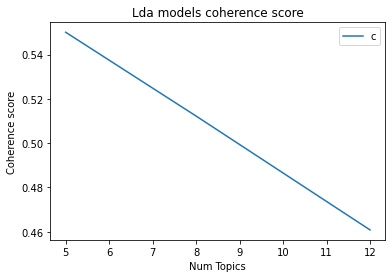

In [30]:
plt.plot(k, [x["coherence"] for x in statistics])
plt.title("Lda models coherence score")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
best, ind = max(zip(statistics, range(len(statistics))), key=lambda x:(x[0]["coherence"], x[1]))
print(f"Best model found:\n{best}")
best_model = lda_models[ind]
print("\nBest model topics:")
best_model.print_topics()

Best model found:
{'topics': 5, 'coherence': 0.5501154613005946, 'log_perplexity': -8.165225386457935}

Best model topics:


[(0,
  '0.011*"injury" + 0.010*"vehicle" + 0.009*"count" + 0.008*"car" + 0.008*"work" + 0.007*"duty" + 0.007*"medical" + 0.006*"west" + 0.005*"drive" + 0.005*"care"'),
 (1,
  '0.016*"west" + 0.014*"ilcs" + 0.014*"respondent" + 0.011*"board" + 0.011*"code" + 0.010*"public" + 0.009*"petition" + 0.008*"district" + 0.007*"department" + 0.007*"city"'),
 (2,
  '0.040*"child" + 0.022*"petition" + 0.018*"petitioner" + 0.014*"parent" + 0.013*"minor" + 0.011*"estate" + 0.011*"home" + 0.011*"marriage" + 0.008*"custody" + 0.008*"west"'),
 (3,
  '0.012*"officer" + 0.010*"police" + 0.010*"sentence" + 0.007*"conviction" + 0.007*"criminal" + 0.006*"offense" + 0.006*"defense" + 0.006*"tell" + 0.005*"guilty" + 0.005*"victim"'),
 (4,
  '0.013*"complaint" + 0.012*"agreement" + 0.012*"policy" + 0.011*"contract" + 0.010*"insurance" + 0.009*"attorney" + 0.008*"fee" + 0.008*"summary" + 0.008*"dismiss" + 0.007*"inc"')]

### pyLDAvis visualization

This tool offers a graphical visualization of the topics, a good visualization has big topics that are far from each others.

In [32]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.047714  0.206101       1        1  25.523870
3     -0.065477  0.071536       2        1  23.467380
0     -0.191946 -0.184468       3        1  21.543840
1     -0.050727  0.052363       4        1  20.371918
2      0.260436 -0.145532       5        1   9.092993, topic_info=              Term           Freq          Total Category  logprob  loglift
2044         child  369750.000000  369750.000000  Default  30.0000  30.0000
475       petition  417378.000000  417378.000000  Default  29.0000  29.0000
4712    respondent  292471.000000  292471.000000  Default  28.0000  28.0000
1039        policy  310606.000000  310606.000000  Default  27.0000  27.0000
633           west  533294.000000  533294.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
1876         month   55336.248011  117371.165806   Topic5  -5.1186   1.6458
979          death   53607.503448  128146.231348   Topic5  -5.1503   1.5262
3113     terminate   39357.188603   66757.307980   Topic5  -5.4593   1.8693
633           west   74230.483132  533294.956482   Topic5  -4.8248   0.4258
2851  relationship   37837.469279  101521.423667   Topic5  -5.4987   1.4107

[337 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
559       1  0.268214     abuse
559       2  0.608384     abuse
559       4  0.123395     abuse
2327      3  0.999996  accident
950       1  0.909038   account
...     ...       ...       ...
633       4  0.623194      west
633       5  0.139191      west
876       1  0.185127      work
876       3  0.745953      work
876       4  0.068920      work

[564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3])

## NOT FOR NOW Putting all together

After presenting the methodology, we run different searches on each era to find the best number of topics, the result is a model for each era that achieved the bet coherence.

In [10]:
tokens_dir = "../data/processed/tokens"
models_dir = "../data/models/lda"
epochs_files = [f"{tokens_dir}/{f}" for f in sorted(os.listdir(tokens_dir))]

min_topics = 8
max_topics = 13

k = range(min_topics, max_topics+1)

best_models = {}
for epoch in epochs_files:
    # extracting year name
    name = int(epoch.split("/")[-1].split(".")[0])
    print(f"Computing best model for {name}:")
    
    # creating required structures
    texts = json.load(open(epoch, "r"))
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # fitting models and picking the best one
    lda_models, statistics = compute_coherence_perplexity_values(corpus, id2word, texts, k, verbose=False)
    best, ind = max(zip(statistics, range(len(statistics))), key=lambda x:x[0]["coherence"])
    print(f"\tBest one: {best}\n")
    best_models[name] = lda_models[ind]
    
    # saving model to disk
    os.makedirs(f"{models_dir}/{name}")
    lda_models[ind].save(f"{models_dir}/{name}/{name}_lda.model")

Computing best model for 1760:
	Best one: {'topics': 3, 'coherence': 0.25392873406498645, 'log_perplexity': -6.232186053236062}

Computing best model for 1800:
	Best one: {'topics': 8, 'coherence': 0.4543540793750551, 'log_perplexity': -5.912878694419498}

Computing best model for 1820:
	Best one: {'topics': 4, 'coherence': 0.4705303380326476, 'log_perplexity': -7.041319240401877}

Computing best model for 1840:
	Best one: {'topics': 9, 'coherence': 0.45529005521185073, 'log_perplexity': -7.43494822339074}

Computing best model for 1860:
	Best one: {'topics': 10, 'coherence': 0.4872247842545204, 'log_perplexity': -7.608953204629182}

Computing best model for 1880:
	Best one: {'topics': 11, 'coherence': 0.48345845693737205, 'log_perplexity': -7.809322282079611}

Computing best model for 1900:


KeyboardInterrupt: 